In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.api import OLS
from scipy.optimize import minimize
from scipy.stats import t, norm, multivariate_normal
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Problem 1

### a

In [2]:
data_1 = pd.read_csv("problem1.csv")
X_1 = data_1['x'].values
mean = np.mean(X_1)
std = np.std(X_1, ddof=1) 
var = np.var(X_1, ddof=1) 
skew = np.mean((X_1 - mean)**3) / std**3
kurt = np.mean((X_1 - mean)**4) / std**4 - 3
print("mean: ", mean)
print("variance ", var)
print("skewness：",skew)
print("kurtosis：", kurt)

mean:  1.0489703904839585
variance  5.427220681881727
skewness： 0.8792880598472443
kurtosis： 23.069982510610544


### b

In [3]:
print("mean：", stats.tmean(X_1))
print("variance：", stats.tvar(X_1))
print("skewness：", stats.skew(X_1))
print("kurtosis：", stats.kurtosis(X_1))

mean： 1.0489703904839585
variance： 5.427220681881727
skewness： 0.8806086425277364
kurtosis： 23.122200789989723


### c

In [4]:
n_bootstrap = 100

manual_means, package_means = [], []
manual_variances, package_variances = [], []
manual_skewnesses, package_skewnesses = [], []
manual_kurtoses, package_kurtoses = [], []

for _ in range(n_bootstrap):
    n = len(data_1)
    bootstrap_sample = data_1.sample(n, replace=True)
    
    mean_manual = np.mean(bootstrap_sample['x'])
    std_manual = np.std(bootstrap_sample['x'], ddof=1)
    variance_manual = np.var(bootstrap_sample['x'], ddof=1)
    skewness_manual = np.mean((bootstrap_sample['x'] - mean_manual) ** 3) / std_manual ** 3
    kurtosis_manual = np.mean((bootstrap_sample['x'] - mean_manual) ** 4) / std_manual ** 4 - 3
    
    manual_means.append(mean_manual)
    manual_variances.append(variance_manual)
    manual_skewnesses.append(skewness_manual)
    manual_kurtoses.append(kurtosis_manual)
    
    mean_package = stats.tmean(bootstrap_sample['x'])
    variance_package = stats.tvar(bootstrap_sample['x'])
    skewness_package = stats.skew(bootstrap_sample['x'])
    kurtosis_package = stats.kurtosis(bootstrap_sample['x'])
    
    package_means.append(mean_package)
    package_variances.append(variance_package)
    package_skewnesses.append(skewness_package)
    package_kurtoses.append(kurtosis_package)

t_test_variance = stats.ttest_rel(manual_variances, package_variances)
t_test_skewness = stats.ttest_rel(manual_skewnesses, package_skewnesses)
t_test_kurtosis = stats.ttest_rel(manual_kurtoses, package_kurtoses)

print(f'Variance: p-value = {t_test_variance.pvalue}')
print(f'Skewness: p-value = {t_test_skewness.pvalue}')
print(f'Kurtosis: p-value = {t_test_kurtosis.pvalue}')

Variance: p-value = 0.20275491720659722
Skewness: p-value = 2.9078696334068604e-08
Kurtosis: p-value = 2.580385926959568e-55


## Problem 2

### a

OLS Results:
Beta OLS: [-0.08738446  0.7752741 ]
Standard Deviation of OLS Residuals: 1.003756319417732


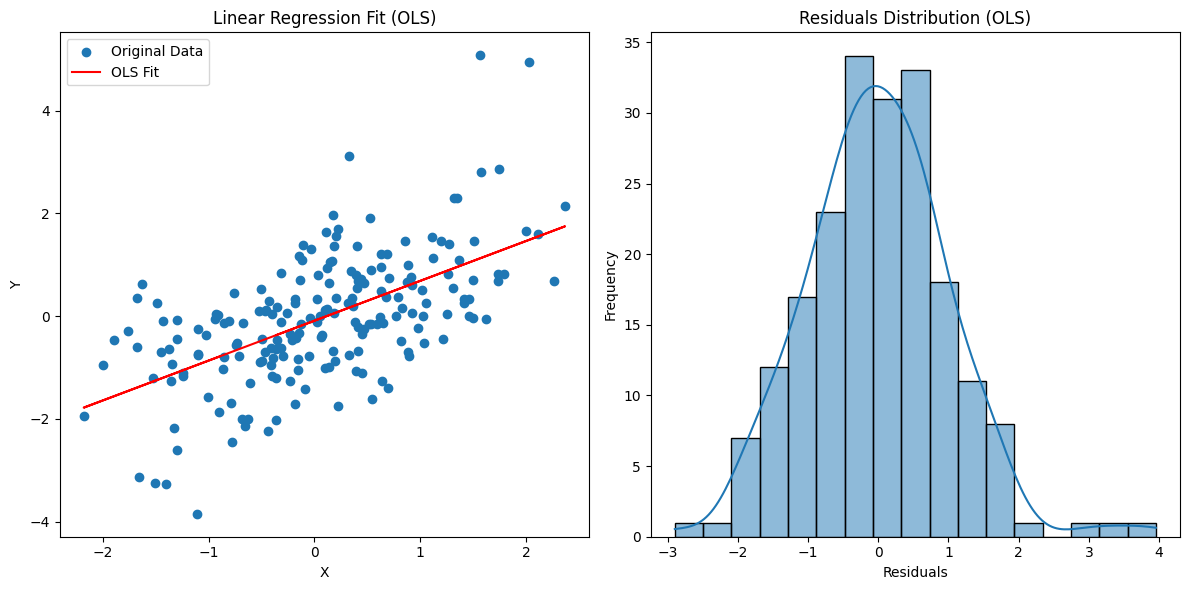

In [5]:
data_2 = pd.read_csv('problem2.csv')

X_2 = data_2['x'].values
Y_2 = data_2['y'].values

X_2_ols = np.column_stack((np.ones_like(X_2), X_2))
ols_model = OLS(Y_2, X_2_ols).fit()
beta_ols = ols_model.params
std_ols_error = np.std(ols_model.resid)
r_squared = ols_model.rsquared

print("OLS Results:")
print(f"Beta OLS: {beta_ols}")
print(f"Standard Deviation of OLS Residuals: {std_ols_error}")



plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_2, Y_2, label='Original Data')
plt.plot(X_2, ols_model.predict(), color='red', label='OLS Fit')
plt.title('Linear Regression Fit (OLS)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

residuals = ols_model.resid
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution (OLS)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

MLE Results Assuming Normality:
Beta MLE: [-0.08738448  0.7752741 ]
Standard Deviation of MLE Residuals: 1.0037563209985647
Pseudo R-squared: 0.15655313865451992


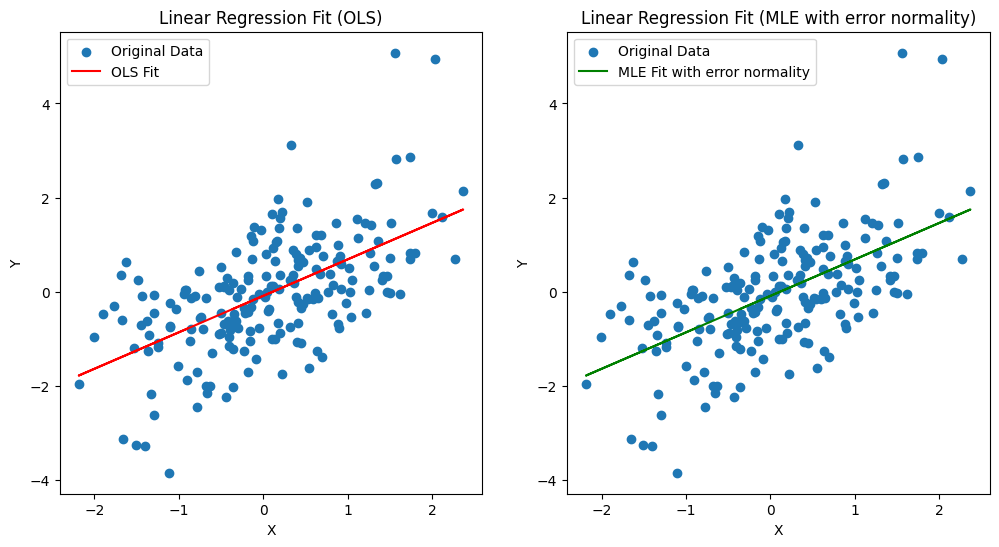

In [6]:
def neg_log_likelihood_normal(params, X, Y):
    beta0, beta1, sigma = params
    y_pred = beta0 + beta1 * X
    ll = -0.5 * len(Y) * np.log(2 * np.pi * sigma**2) - 0.5 * np.sum((Y - y_pred)**2) / sigma**2
    return -ll

initial_params_mle = [0, 1, 1]

result_mle = minimize(neg_log_likelihood_normal, initial_params_mle, args=(X_2, Y_2))
beta_mle = result_mle.x[:2]
sigma_mle = result_mle.x[2]
pseudo_r_squared = 1 - (neg_log_likelihood_normal(result_mle.x, X_2, Y_2) / neg_log_likelihood_normal([np.mean(Y_2), 0, sigma_mle], X_2, Y_2))

print("MLE Results Assuming Normality:")
print(f"Beta MLE: {beta_mle}")
print(f"Standard Deviation of MLE Residuals: {sigma_mle}")
print(f"Pseudo R-squared: {pseudo_r_squared}")


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_2, Y_2, label='Original Data')
plt.plot(X_2, ols_model.predict(), color='red', label='OLS Fit')
plt.title('Linear Regression Fit (OLS)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X_2, Y_2, label='Original Data')
plt.plot(X_2, beta_mle[0] + beta_mle[1] * X_2, color='green', label='MLE Fit with error normality')
plt.title('Linear Regression Fit (MLE with error normality)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

plt.show()

### b

MLE Results Assuming T Distribution:
Beta MLE: [-0.09619106  0.72658199]
Standard Deviation of MLE Residuals: 1.0
Degrees of Freedom: 17.355088460702405


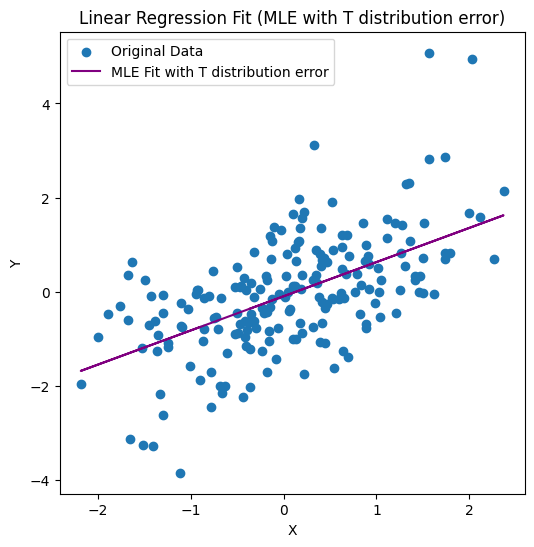

In [7]:
def neg_log_likelihood_t(params, X, Y):
    beta0, beta1, sigma, df = params
    y_pred = beta0 + beta1 * X
    residuals = Y - y_pred
    ll = np.sum(t.logpdf(residuals, df))
    return -ll

initial_params_t = [0, 1, 1, 10]

result_t = minimize(neg_log_likelihood_t, initial_params_t, args=(X_2, Y_2))
beta_t, sigma_t, df_t = result_t.x[:2], result_t.x[2], result_t.x[3]

print("MLE Results Assuming T Distribution:")
print(f"Beta MLE: {beta_t}")
print(f"Standard Deviation of MLE Residuals: {sigma_t}")
print(f"Degrees of Freedom: {df_t}")


plt.figure(figsize=(6, 6))
plt.scatter(X_2, Y_2, label='Original Data')
plt.plot(X_2, beta_t[0] + beta_t[1] * X_2, color='purple', label='MLE Fit with T distribution error')
plt.title('Linear Regression Fit (MLE with T distribution error)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

### c

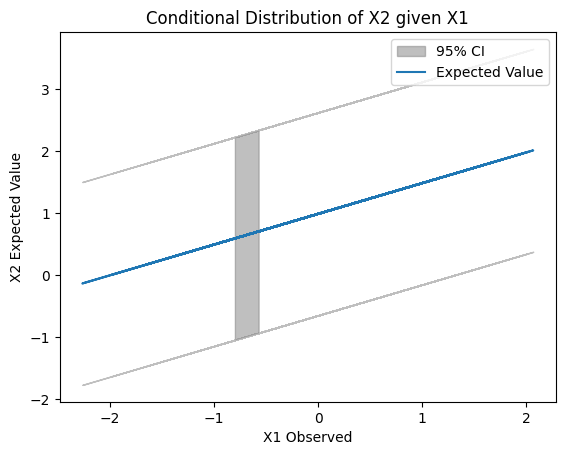

In [8]:
data_x = pd.read_csv('problem2_x.csv')
data_x1 = pd.read_csv('problem2_x1.csv')

x1 = data_x['x1'].values
x2 = data_x['x2'].values
x_observed = data_x1['x1'].values

mu1 = np.mean(x1)
mu2 = np.mean(x2)
sigma11 = np.var(x1, ddof=1)
sigma22 = np.var(x2, ddof=1)

cov_matrix = np.cov(x1, x2, ddof=1)
sigma12 = cov_matrix[0, 1]

mu_hat = mu2 + (sigma12 / sigma11) * (x_observed - mu1)
sigma_hat = sigma22 - (sigma12**2 / sigma11)

z = norm.ppf(0.975)
margin_error = z * np.sqrt(sigma_hat)
lower_bound = mu_hat - margin_error
upper_bound = mu_hat + margin_error

plt.fill_between(x_observed, lower_bound, upper_bound, color='gray', alpha=0.5, label='95% CI')
plt.plot(x_observed, mu_hat, label='Expected Value')
plt.legend()
plt.xlabel('X1 Observed')
plt.ylabel('X2 Expected Value')
plt.title('Conditional Distribution of X2 given X1')
plt.show()

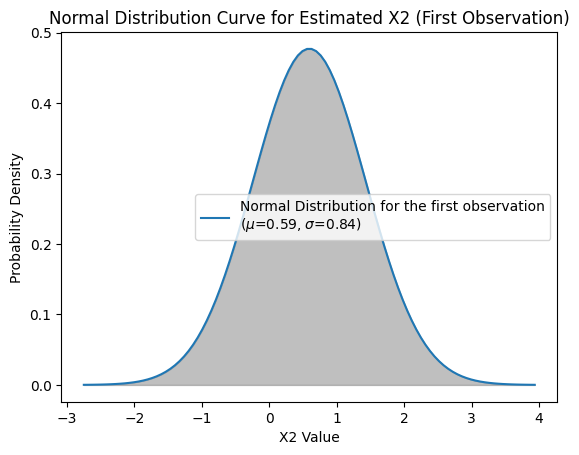

In [9]:
x = np.linspace(mu_hat[0] - 4 * np.sqrt(sigma_hat), mu_hat[0] + 4 * np.sqrt(sigma_hat), 100)
pdf = (1 / (np.sqrt(2 * np.pi * sigma_hat))) * np.exp(-(x - mu_hat[0])**2 / (2 * sigma_hat))

plt.plot(x, pdf, label=f'Normal Distribution for the first observation\n($\mu$={mu_hat[0]:.2f}, $\sigma$={np.sqrt(sigma_hat):.2f})')
plt.fill_between(x, pdf, color='gray', alpha=0.5)

plt.xlabel('X2 Value')
plt.ylabel('Probability Density')
plt.title('Normal Distribution Curve for Estimated X2 (First Observation)')
plt.legend()
plt.show()


## Problem 3

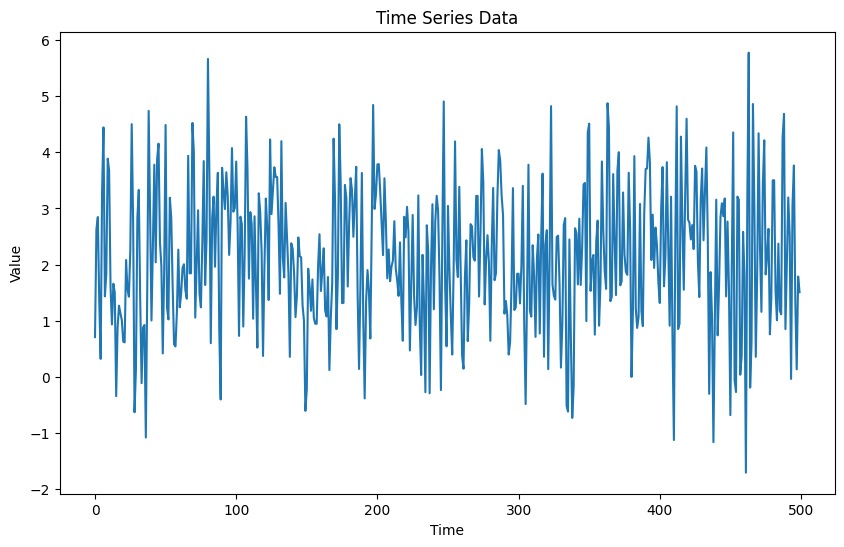

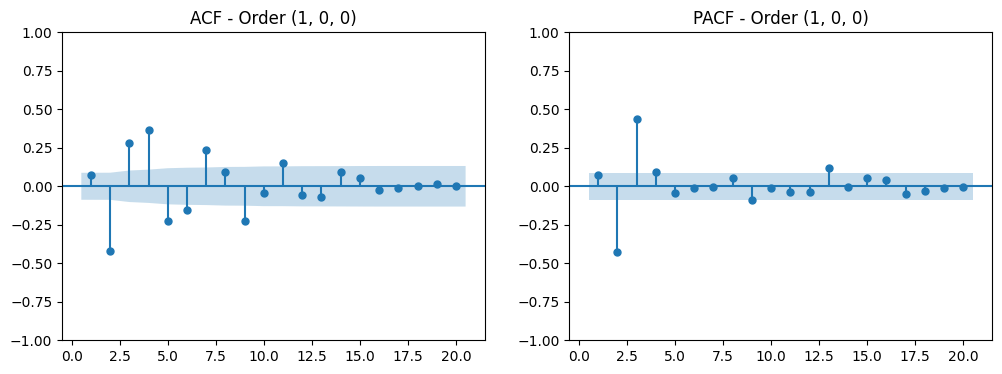

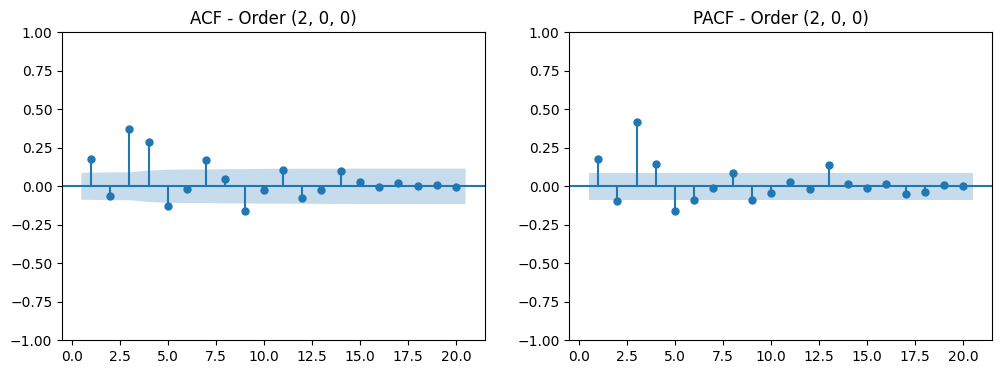

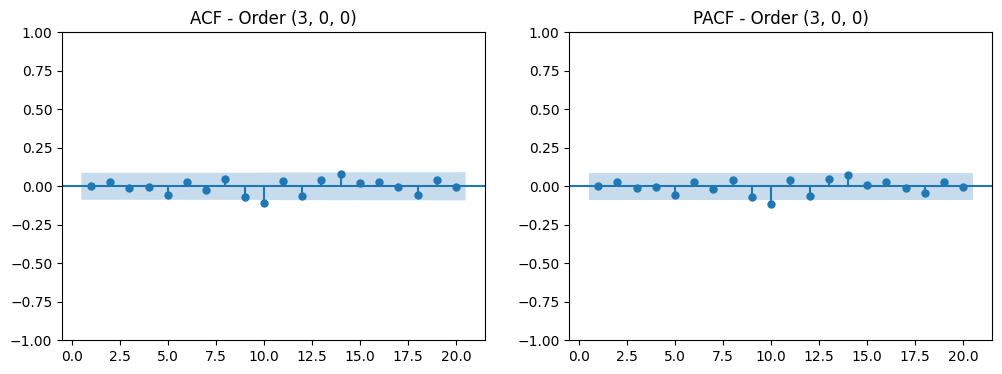

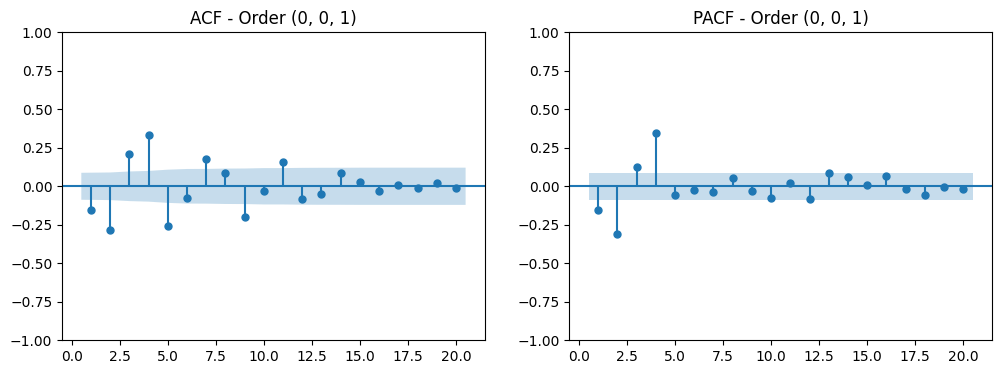

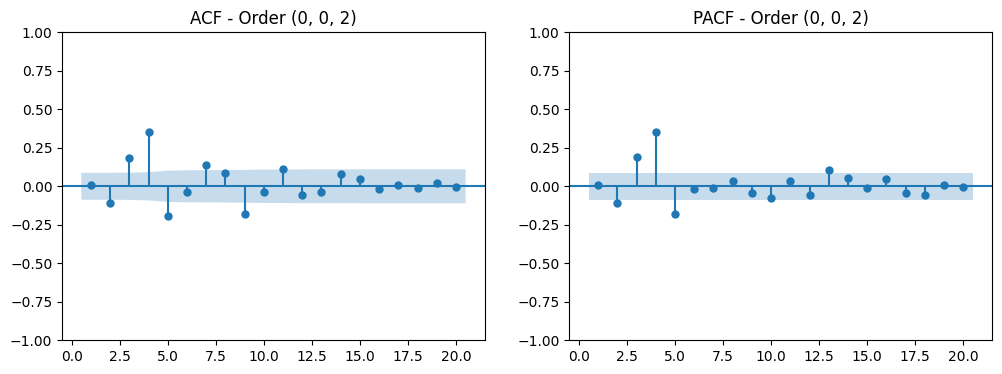

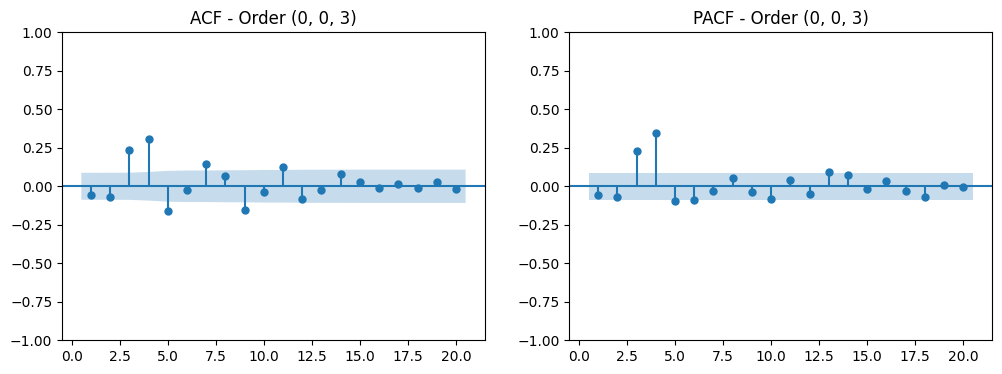

In [10]:
data_3 = pd.read_csv('problem3.csv')
time_series = data_3['x']

plt.figure(figsize=(10, 6))
plt.plot(time_series)
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

def fit_arima_model(order, time_series):
    model = ARIMA(time_series, order=order)
    results = model.fit()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    plot_acf(results.resid, lags=20, ax=ax1, title=f'ACF - Order {order}', zero=False)

    plot_pacf(results.resid, lags=20, ax=ax2, title=f'PACF - Order {order}', zero=False)

    plt.show()

for p in range(1, 4):
    fit_arima_model((p, 0, 0), time_series)

for q in range(1, 4):
    fit_arima_model((0, 0, q), time_series)



In [11]:
def fit_arima_and_get_stats(order, time_series):
    model = ARIMA(time_series, order=order)
    results = model.fit()
    aic = results.aic
    bic = results.bic
    return aic, bic

stats = {}

for p in range(1, 4):
    stats[f'AR({p})'] = fit_arima_and_get_stats((p, 0, 0), time_series)

for q in range(1, 4):
    stats[f'MA({q})'] = fit_arima_and_get_stats((0, 0, q), time_series)

stats_df = pd.DataFrame(stats, index=['AIC', 'BIC']).T
stats_df


,AIC,BIC
AR(1),1644.655505,1657.299329
AR(2),1581.079266,1597.937698
AR(3),1436.659807,1457.732847
MA(1),1567.403626,1580.047451
MA(2),1537.941206,1554.799639
MA(3),1536.867709,1557.940749
